# Metropolist Hastings

### Preparation

Before we start, we need to download the plotting library [EvilPlot](https://cibotech.github.io/evilplot/) and make it available in the Jupyter-Notebook. It may take some time when you execute the following cells for the first time. 

In [40]:
interp.repositories() ++= Seq(
  coursierapi.MavenRepository.of("https://dl.bintray.com/cibotech/public")
)

In [41]:
import $ivy.`com.cibo::evilplot-repl:0.7.0`

import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.renderers.PointRenderer

import com.cibo.evilplot.plot.aesthetics.DefaultTheme._
import com.cibo.evilplot.numeric.Point
import com.cibo.evilplot.colors._
import breeze.linalg.{DenseVector, DenseMatrix}

def showPlot(plot: com.cibo.evilplot.geometry.Drawable) = 
  Image.fromRenderedImage(plot.asBufferedImage, Image.PNG)


import $ivy.$                              


import com.cibo.evilplot.plot._

import com.cibo.evilplot.plot.renderers.PointRenderer


import com.cibo.evilplot.plot.aesthetics.DefaultTheme._

import com.cibo.evilplot.numeric.Point

import com.cibo.evilplot.colors._

import breeze.linalg.{DenseVector, DenseMatrix}


defined function showPlot

We also initialize a global random number generator, which we use whenever we need a new random number in our algorithm.

In [42]:
// We keep random number generator around as global state
val rng = new scala.util.Random()

rng: scala.util.Random = scala.util.Random@72f95dce

### The Metropolis algorithm

We start by making some type definitions, such that the definitions of the functions we will define below become more clear. 

In our example we define a distribution via the probabilisty density function (pdf). As we are working with random vectors, the pdf maps a vector of values to the corresponding density value.

In [47]:
type PDF = DenseVector[Double] => Double


defined type PDF

The Metropolis algorithm works by simulating a random path through the points on which the PDF is defined. We call each possible point on the path a ```State```. 

In [52]:
type State = DenseVector[Double]


defined type State

The algorithm advanced by moving from one state to a new state. A possible new state is proposed using a proposal function. The proposal function takes a state and return a new state.

In [53]:
type Proposal = State => State

defined type Proposal

For visualization and diagnostic purposes, it will be interesting to keep track during the run of the algorithm whether a newly proposed state was accepted. We therefore introduce a new type ```StateWithInfo```, which, along with a state, also keeps the information which state was proposed. 

In [51]:
case class StateWithInfo(state : State, proposedState : State) {
    def isAccepted : Boolean = state == proposedState
}

defined class StateWithInfo


With these definitions, we are ready to implement the metropolis sampler. 

In [132]:
def metropolisSampler(pdf :PDF, proposal : Proposal, x0 : State, numIterations : Int) : Seq[StateWithInfo] = {

    
    def nextStep(x : State) : StateWithInfo = {
        val xNew = proposal(x)
        val r = rng.nextDouble()
        
        val alpha  = scala.math.min(1.0, pdf(xNew) / pdf(x));
        if (r < alpha) {
            StateWithInfo(xNew, xNew)
        } else {
            StateWithInfo(x, xNew)
        }
    }
    
    var currentState = x0
    val samples = for (i <- 0 until numIterations) yield {
        val StateWithInfo(newState, proposedState) = nextStep(currentState)
        currentState = newState
        StateWithInfo(newState, proposedState)
    }
    samples.toSeq
}

defined function metropolisSampler

### Simple example: Sampling from a bivariate normal distribution

We can now use the sample to sample from a probability distribution. To experiment with the sampler, we start with a simple bivariate normal distribution. 

In [133]:
import breeze.stats.distributions.MultivariateGaussian 

def bivariatePDF(x : DenseVector[Double]) : Double = {
    val mean = DenseVector(9.0, 7.0)
    val cov = DenseMatrix((1.0, 0.9), (0.9, 1.0))
    val dist = MultivariateGaussian(mean, cov)
    
    dist.pdf(x)
}

import breeze.stats.distributions.MultivariateGaussian 


defined function bivariatePDF

We also need to define a proposal generator. We define a simple random walk proposal, which chooses the new direction and step length randomly.

In [118]:
def randomWalkProposal(x : State) : State = {
    val stepLength = 1.0
    
    val step = DenseVector(rng.nextGaussian() * stepLength, rng.nextGaussian() * stepLength)
    x + step
}

defined function randomWalkProposal

Now we can draw samples using our sampler:

In [119]:
val samples = metropolisSampler(bivariatePDF, randomWalkProposal, DenseVector(0.0, 0.0),1000)

samples: Seq[StateWithInfo] = Vector(
  StateWithInfo(
    DenseVector(0.4530755110527174, -1.01780025951008),
    DenseVector(0.4530755110527174, -1.01780025951008)
  ),
  StateWithInfo(
    DenseVector(0.4530755110527174, -1.01780025951008),
    DenseVector(-0.6044086682180319, -2.3288059837013604)
  ),
  StateWithInfo(
    DenseVector(0.4530755110527174, -1.01780025951008),
    DenseVector(0.4570410490058792, -2.246820314238184)
  ),
  StateWithInfo(
    DenseVector(0.4530755110527174, -1.01780025951008),
    DenseVector(0.5959660512153976, -1.850047109405252)
  ),
  StateWithInfo(
    DenseVector(0.4530755110527174, -1.01780025951008),
    DenseVector(0.021719211489836854, -1.5208752833834849)
  ),
  StateWithInfo(
    DenseVector(0.4530755110527174, -1.01780025951008),
    DenseVector(-0.275829227326871, -1.207860700978602)
  ),
  StateWithInfo(
    DenseVector(0.4530755110527174, -1.01780025951008),
    DenseVector(-0.21922669289098462, -0.11229525911646887)
  ),
  StateWithInfo(

To understand how the metropolis algorithm works, it is interesting to visualize not only the accepted samples, but also those which are rejected, and possibly the path that was taken. This is achieved by the following plot function. 

In [120]:
def plot(samples : Seq[StateWithInfo], plotRejected : Boolean = false, plotLines : Boolean = false) : Image = {
    
    val acceptedPlot = ScatterPlot.series(
        samples.filter(s => s.isAccepted).map(s => Point(s.state(0), s.state(1))), 
        "accepted", 
        HTMLNamedColors.blue, 
        pointSize = Some(3)
    )
    val rejectedPlot = ScatterPlot.series(
        samples.filter(s => s.state != s.proposedState).map(s => Point(s.proposedState(0), s.proposedState(1))),
        "rejected", 
        HTMLNamedColors.red ,
        pointSize = Some(3)  
    )
    val linePlot =  LinePlot(
        samples.flatMap(s => 
                        if (!s.isAccepted) {        
                            Seq(Point(s.proposedState(0), s.proposedState(1)), Point(s.state(0), s.state(1)))
                        } else {
                            Seq(Point(s.state(0), s.state(1)))
                        })
    )
    var plots = Seq(acceptedPlot)
    if (plotRejected) plots = plots :+ rejectedPlot
    if (plotLines) plots = plots :+ linePlot
    
    val plot = Overlay.fromSeq(plots)
    .xAxis()
    .xbounds(-20, 20)
    .yAxis()
    .ybounds(-20, 20)
    .frame()
    .xLabel("x")
    .yLabel("y")
    .rightLegend()
    .render()
    showPlot(plot)
}

defined function plot

We can now plot our samples and start experimenting:

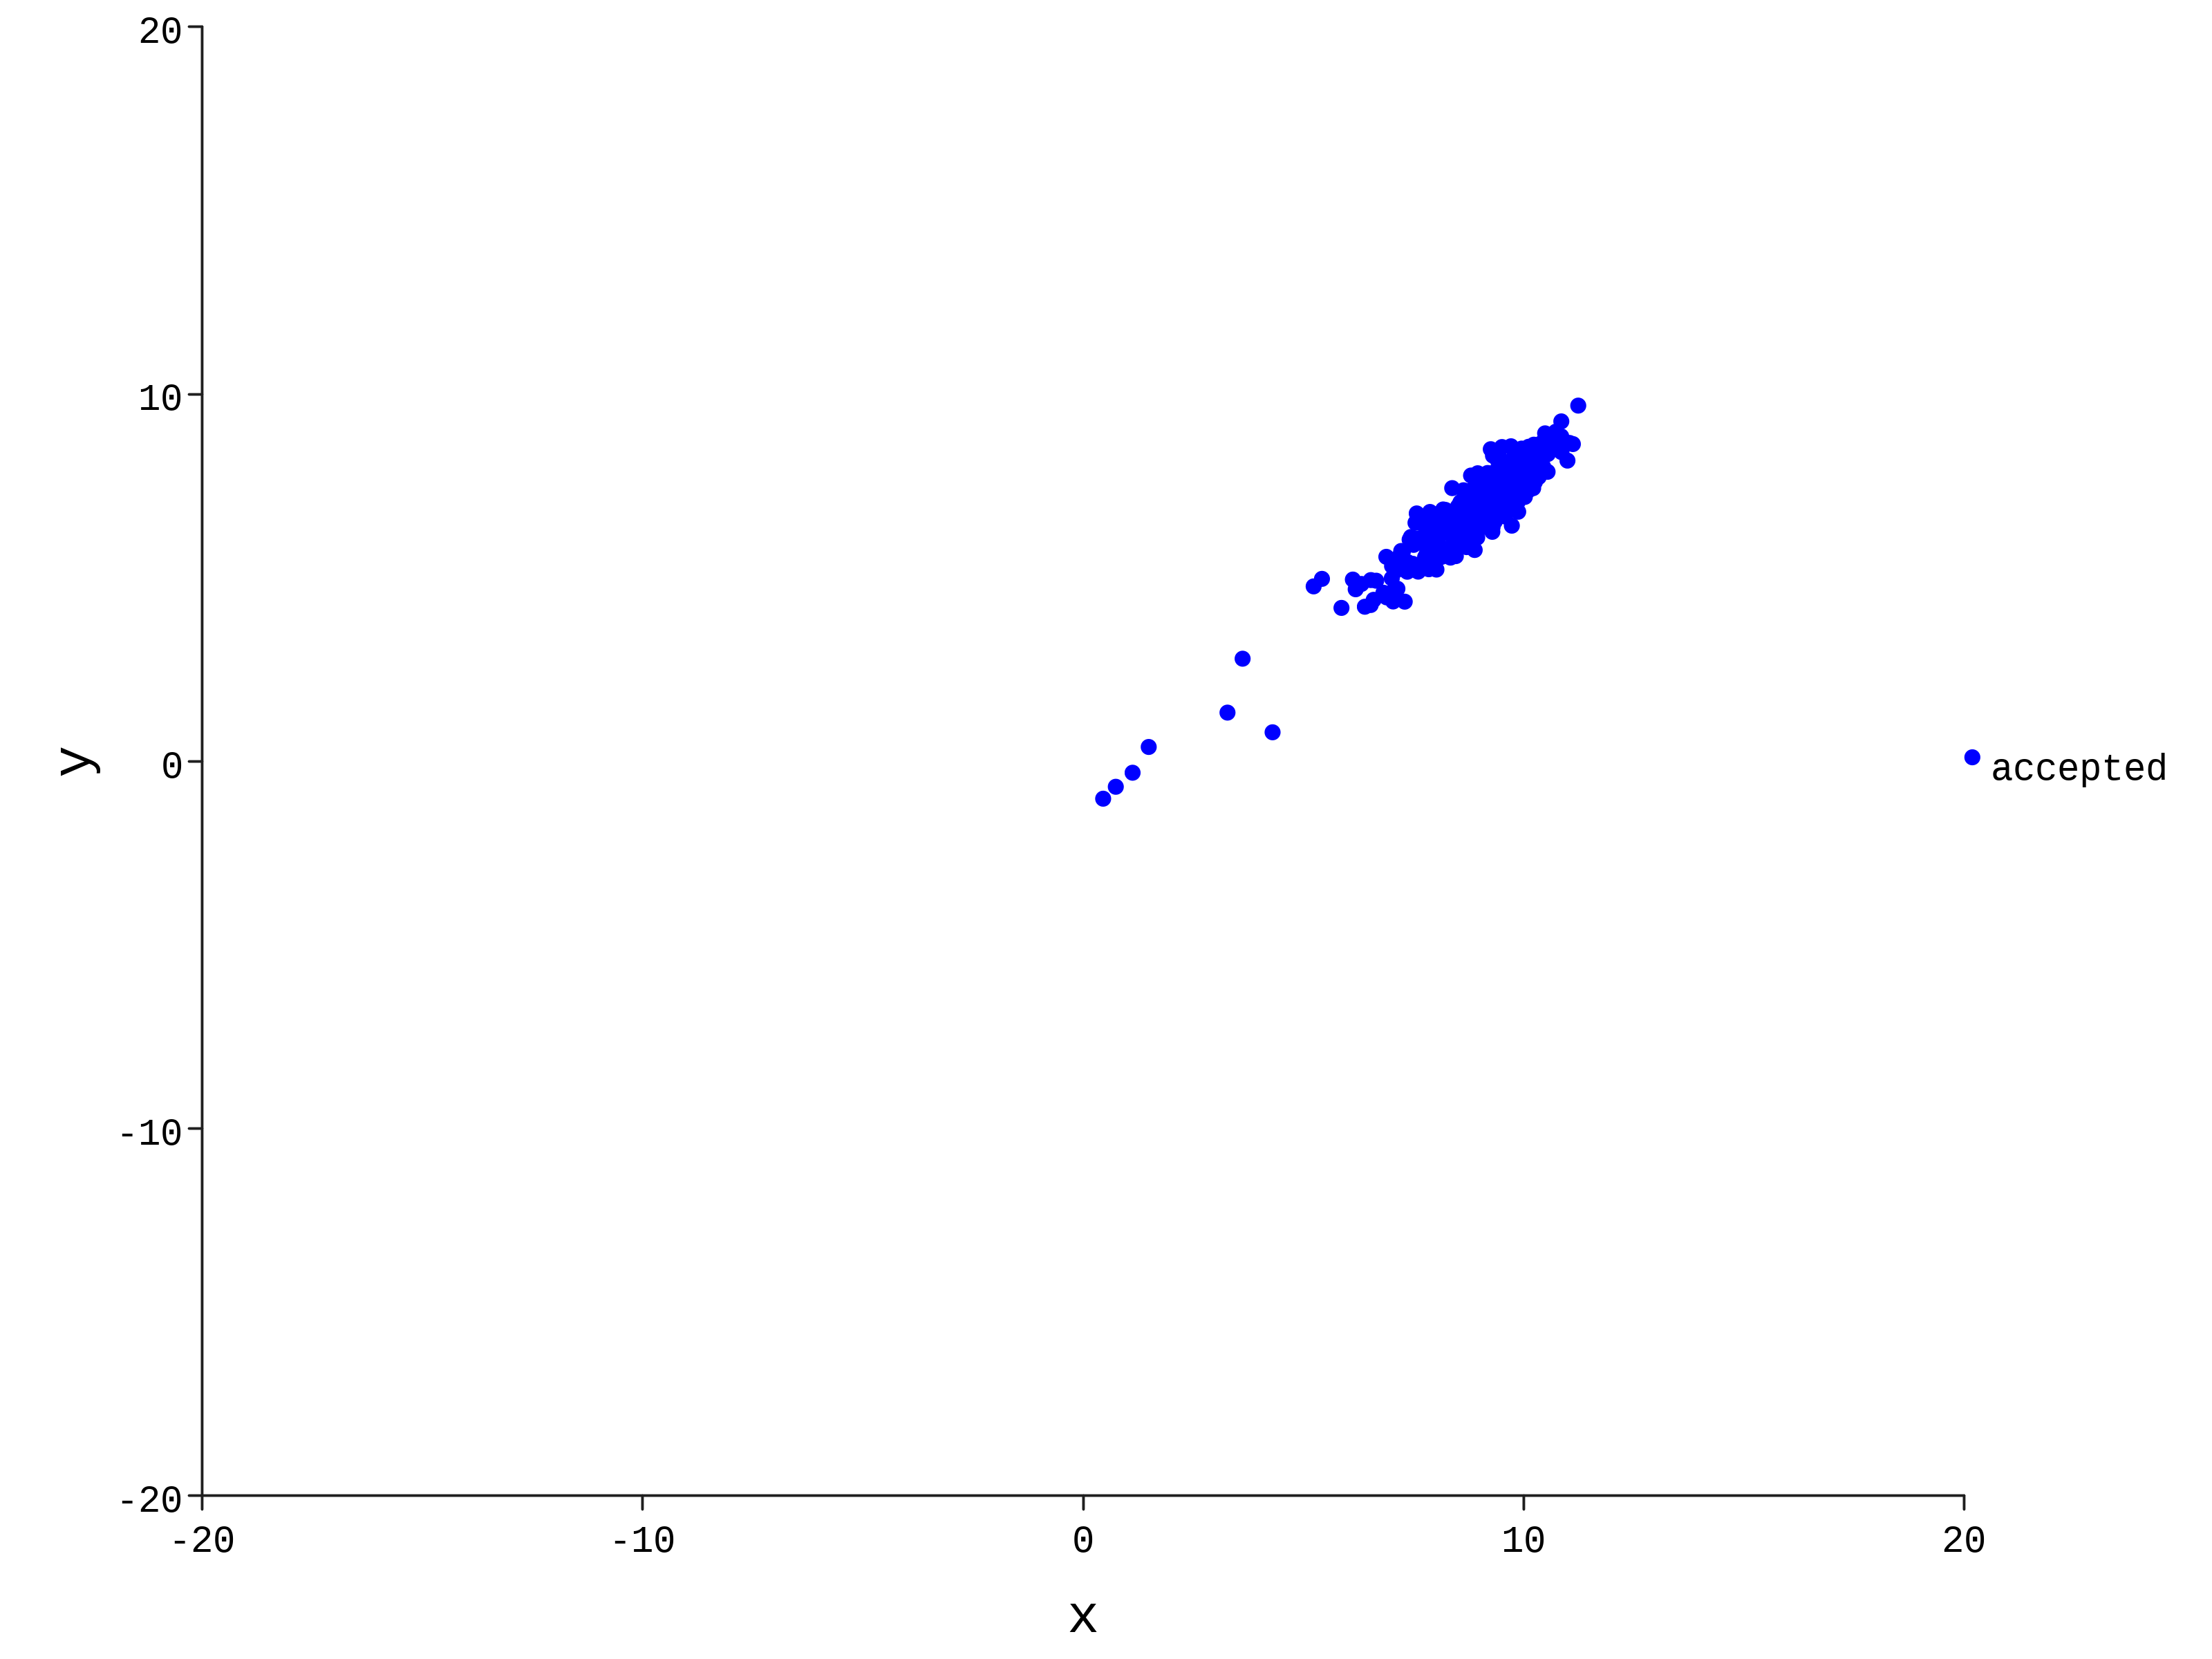

In [121]:
plot(samples, plotRejected = false, plotLines = false)

#### Exercises

* Draw only a few samples and trace the path (set ```plotLines = true``` in the plot function). 
    * We usually throw away the first samples when we run a chain. Can you see why?
* Play with different step-length in the proposal.
    * What happens to the acceptance and rejection rate? 
    * How well is the target distribution approximated after a fixed number of samples
* Experiment with different target distributions. 
    * Make the variance larger and smaller
    * Change the correlation 
    * Give all samples whose x value is larger then 5 the probability 0. 
        * Do you need to normalize the pdf? why, why not?


### Estimating quantities

Now that we have samples, we can start estimating interesting quantities. 
For example, we can use the samples to estimate the mean and covariance:

In [123]:
def mean(samples : Seq[DenseVector[Double]]) : DenseVector[Double] = {
    val zeroVec = DenseVector.zeros[Double](samples(0).length)
    samples.foldLeft(zeroVec)((acc, s) => acc + s) * (1.0 / samples.size)
}

def cov(samples : Seq[DenseVector[Double]]) : DenseMatrix[Double] = {
    val zeroMat = DenseMatrix.zeros[Double](samples(0).size, samples(0).size)
    samples.foldLeft(zeroMat)((acc, s) => (acc + s * s.t)) * (1.0 / samples.size)
}

defined function mean
defined function cov

To call these functions, we strip away the debugging information (i.e. the state that was proposed) that we stored along with the state.

In [128]:
val sampledStates = samples.map(s => s.state)
mean(sampledStates)
cov(sampledStates)

sampledStates: Seq[State] = Vector(
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.4530755110527174, -1.01780025951008),
  DenseVector(0.7397040531221313, -0.693422942389246),
  DenseVector(0.7397040531221313, -0.693422942389246),
  DenseVector(0.7397040531221313, -0.693422942389246),
  DenseVector(0.7397040531221313, -0.693422942389246),
  DenseVector(1.1210760302745197, -0.31068933005497973),
  DenseVector(1.4871368790690482, 0.39081483764184516),
  DenseVector(1.4871368790690482, 0.39081483764184516),
  DenseVector(4.298324110227206, 0.

We can also use the samples to estimate the expected value of a function:

In [130]:
def expectation(samples : Seq[DenseVector[Double]], f : DenseVector[Double] => Double) : Double = {
    samples.map(f).sum / samples.size
}

defined function expectation

In this example we use the samples to compute the expectation of the function $$x \mapsto sin(x_0) \cdot sin(x_1)$$

In [131]:
expectation(sampledStates, (x : DenseVector[Double]) => math.sin(x(0) * math.sin(x(1))))

res130: Double = 0.12739996601776252

### Exercise

* How do you obtain an expectation over the marginal distribution?